In [17]:
# Core
import os
import cv2
import numpy as np
import pandas as pd
import collections
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [18]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('pranavraikokte/covid19-image-dataset',unzip=True)

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset


In [20]:
# Load Training Data (80%)
train_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Validation Data (20%)
val_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(128, 128),
    seed=7
)

# Load Test Data (separate folder)
test_ds = keras.utils.image_dataset_from_directory(
    directory='./Covid19-dataset/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=False
)

Found 251 files belonging to 3 classes.
Using 201 files for training.
Found 251 files belonging to 3 classes.
Using 50 files for validation.
Found 66 files belonging to 3 classes.


In [21]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [22]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)


(32, 128, 128, 3)
(32,)


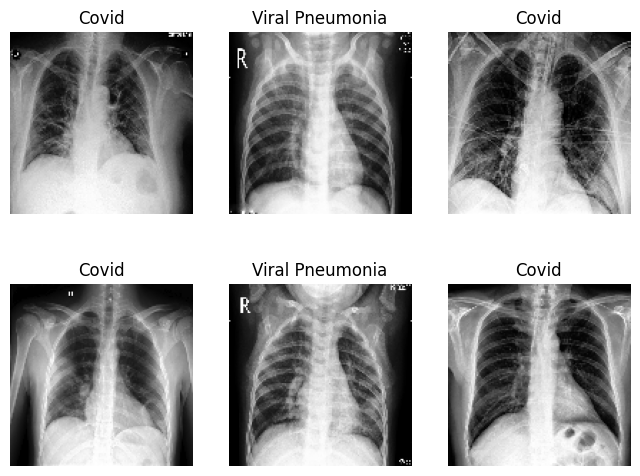

In [23]:
plt.figure(figsize=(8,6))
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


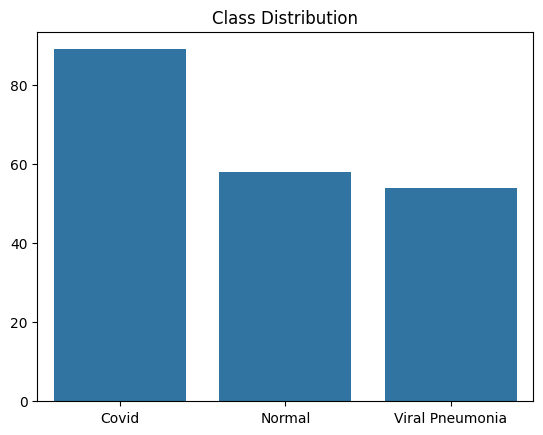

In [24]:
label_count = collections.Counter()

for _, labels in train_ds:
    label_count.update(labels.numpy())

sns.barplot(x=list(label_count.keys()),
            y=list(label_count.values()))
plt.xticks(range(len(class_names)), class_names)
plt.title("Class Distribution")
plt.show()

In [25]:
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
test_ds = test_ds.map(
    lambda x, y: (normalization_layer(x), y)
)
val_ds = val_ds.map(
    lambda x, y: (normalization_layer(x), y)
)

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [28]:
model = keras.Sequential([
    # Input Layer (Explicit definition helps with debugging)
    layers.Input(shape=(128, 128, 3)),
    
    # Data Augmentation (Active only during training)
    data_augmentation,
    
    # Block 1
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Classification Head
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
start_time = time.time()

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Stop if model gets worse 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# 2. Reduce Learning Rate if model stops improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      
    patience=10,      
    min_lr=0.00001   
)

# Train with both callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500, 
    callbacks=[early_stopping, reduce_lr] 
)

end_time = time.time()
total_time = end_time - start_time

print(f"Training time: {total_time:.2f} seconds")
print(f"Training time: {total_time/60:.2f} minutes")

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.3930 - loss: 1.0951 - val_accuracy: 0.4400 - val_loss: 1.0898 - learning_rate: 1.0000e-04
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4378 - loss: 1.0859 - val_accuracy: 0.4400 - val_loss: 1.0859 - learning_rate: 1.0000e-04
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4726 - loss: 1.0818 - val_accuracy: 0.4400 - val_loss: 1.0833 - learning_rate: 1.0000e-04
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4328 - loss: 1.0829 - val_accuracy: 0.4400 - val_loss: 1.0813 - learning_rate: 1.0000e-04
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4428 - loss: 1.0752 - val_accuracy: 0.4400 - val_loss: 1.0803 - learning_rate: 1.0000e-04
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4328 - loss: 1.0809 - val_accuracy: 0.4400 - val_loss: 1.0797 - learning_rate: 1.0000e-04
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4478 - loss

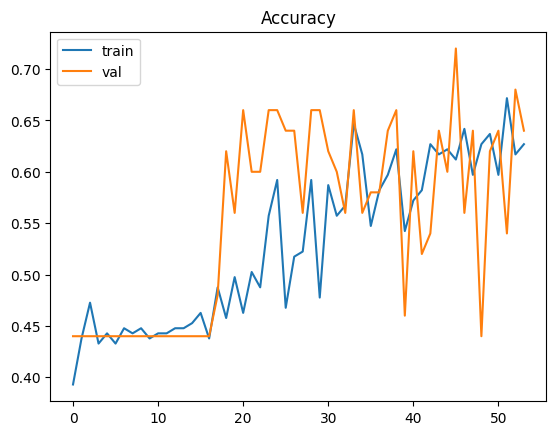

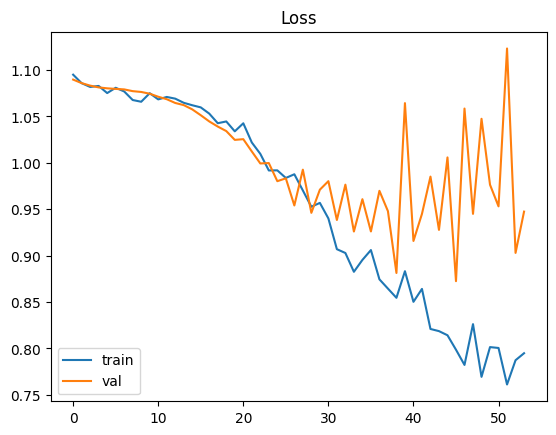

In [30]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


2026-01-03 18:36:05.583452: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


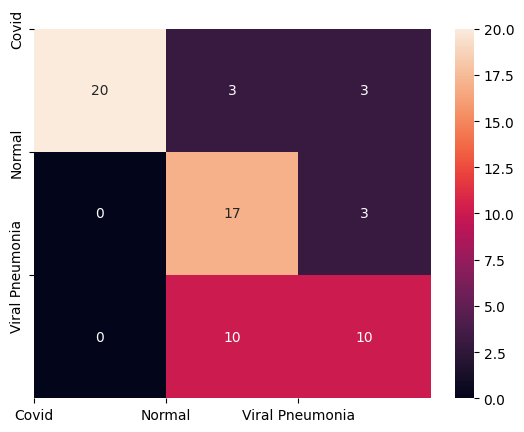

In [31]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d')
plt.xticks(range(3), class_names)
plt.yticks(range(3), class_names)
plt.show()


In [32]:
print(classification_report(
    y_true, y_pred,
    target_names=class_names
))

                 precision    recall  f1-score   support

          Covid       1.00      0.77      0.87        26
         Normal       0.57      0.85      0.68        20
Viral Pneumonia       0.62      0.50      0.56        20

       accuracy                           0.71        66
      macro avg       0.73      0.71      0.70        66
   weighted avg       0.76      0.71      0.72        66

